In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras.layers import Dense, concatenate, Input
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
import matplotlib.animation as animation
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer


# Parameters
* noise_dim
* lambda_reg
* optimizers.Adam: lr, beta
* Generator and Discriminator layers


In [2]:
PATH = "./CollisionData/"

In [3]:
def load(file):
    df = pd.read_csv(PATH+'He_300_rough_collision.dat', sep=' ', index_col=0, 
                 names=['time', 'temp', 'c1', 'c2', 'c3', 'x1', 'x2', 'x3'])
    
    input_c = df[['c1', 'c2', 'c3']].values
    input_c[:,2] = np.abs(input_c[:,2])
    output_x = df[['x1', 'x2', 'x3']].values

    input_c = tf.cast(input_c, tf.float32)
    output_x = tf.cast(output_x, tf.float32)

    return input_c, output_x

def density_plot(inp_trans, out_trans, num_first, list_lim):

    fig, axs = plt.subplots(ncols=4, figsize=(20,4))

    for i in range(3):
        sns.kdeplot(inp_trans[:num_first,i], out_trans[:num_first,i],  n_levels=10, 
                    cmap="Blues", shade=True, shade_lowest=False, ax=axs[i])
        sns.regplot(inp_trans[:num_first,i],out_trans[:num_first,i], scatter=False, 
                    color='blue', ax=axs[i])
        axs[i].set_xlim(list_lim[i])
        axs[i].set_ylim(list_lim[i])

    sns.kdeplot(np.sum(inp_trans[:num_first]**2, axis=1), np.sum(out_trans[:num_first]**2, axis=1),  
                n_levels=10, cmap="Blues", shade=True, shade_lowest=False, ax=axs[3])
    sns.regplot(np.sum(inp_trans[:num_first]**2, axis=1), np.sum(out_trans[:num_first]**2, axis=1), 
                scatter=False, color='blue', ax=axs[3])
    axs[3].set_xlim(list_lim[3])
    axs[3].set_ylim(list_lim[3])
    

In [4]:
inp, out = load(PATH+'He_300_rough_collision.dat')
scale = QuantileTransformer(n_quantiles=500, output_distribution='normal')
inp_trans = scale.fit_transform(inp)
out_trans = scale.transform(out)

inp_trans = tf.cast(inp_trans, tf.float32)
out_trans = tf.cast(out_trans, tf.float32)

# collision_data = np.tanh(tf.concat([inp_trans, out_trans], axis=1))
# collision_data = tf.concat([inp_trans, out_trans], axis=1)
collision_data = tf.concat([inp, out], axis=1)



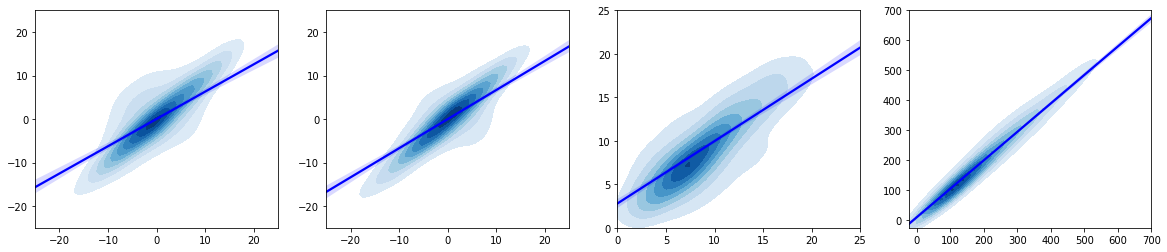

In [5]:
num_first = 1000
# list_lim=[[-1,1],[-1,1],[-1,1],[0,1]]
list_lim=[[-25,25],[-25,25],[0,25],[-25,700]]

plot_data = collision_data.numpy()
density_plot(plot_data[:,:3], plot_data[:,3:], num_first, list_lim)


## Generator 
  * The input 6 noise values z.
  * The output are 6 values x
  
## Discriminator
* The input are 6 target/G_fake values x.
* The output is one scale value.

In [6]:
noise_dim = 6
gen_dim = 6
initializer = tf.random_normal_initializer(0., 1)

def Generator():
    inp_noise = Input(shape=[noise_dim,], name='noise')
    X = Dense(32, activation='relu')(inp_noise)
    X = Dense(32, activation='relu')(X)
    X = Dense(16, activation='relu')(X)
    last = Dense(gen_dim)(X)
    
    return tf.keras.Model(inputs=inp_noise, outputs=last, name='Generator')

def Discriminator():
    inp_data = tf.keras.layers.Input(shape=[gen_dim,], name='input')
    X = Dense(32, activation='relu')(inp_data)
    X = Dense(32, activation='relu')(X)
    X = Dense(16, activation='relu')(X)
    last = Dense(1)(X)
    
    return tf.keras.Model(inputs=inp_data, outputs=last, name='Discriminator')

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise (InputLayer)           [(None, 6)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                224       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 102       
Total params: 1,910
Trainable params: 1,910
Non-trainable params: 0
_________________________________________________________________
Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Out

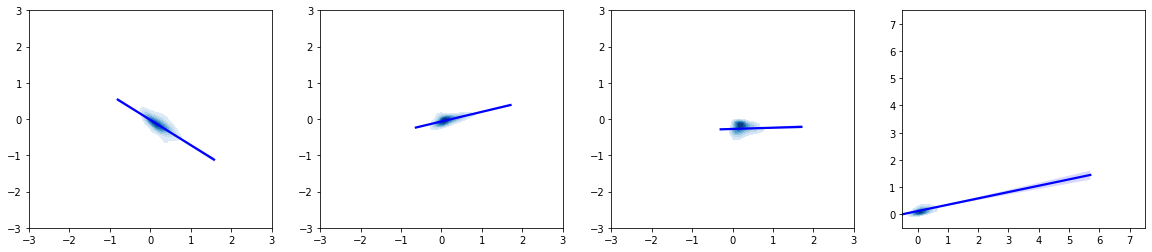

In [7]:
num_test = 1000
generator = Generator()
discriminator = Discriminator()
generator.summary()
discriminator.summary()


noise = tf.random.normal([num_test, noise_dim])
generated_out = generator(noise, training=False)

decision = discriminator(generated_out)

# print(generated_out)
# print(decision)
list_lim=[[-3,3],[-3,3],[-3,3],[-0.5,7.5]]
density_plot(generated_out.numpy()[:,:3], generated_out.numpy()[:,3:], num_test, list_lim)

## Define the loss and optimizers
Define loss functions and optimizers for both models.

In [8]:
lambda_reg = .5

def discriminator_loss(D_real, D_fake, penalty):
    D_loss = tf.reduce_mean(D_fake - D_real + lambda_reg * penalty)
    return D_loss

def generator_loss(D_fake):
    G_loss = -tf.reduce_mean(D_fake)
    return G_loss


In [9]:
generator_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5, beta_2=0.9)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop

In [10]:
def penalty_calculation(X_real, G_fake):
    # Create the gradient penalty operations.
    epsilon = tf.random.uniform(shape=tf.shape(X_real), minval=0., maxval=1.)
    interpolation = epsilon * X_real + (1 - epsilon) * G_fake
    with tf.GradientTape() as pena_tape:
        pena_tape.watch(interpolation)
        penalty = (tf.norm(
            pena_tape.gradient(discriminator(interpolation), interpolation),
            axis=1) - 1) ** 2.0
    
    return penalty

### Train discriminator and generator with same iteration number

In [11]:
@tf.function
def train_step(dataset):
    noise = tf.random.normal([dataset.shape[0], noise_dim],mean=0.0, stddev=1.0, dtype=tf.dtypes.float32)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        G_fake = generator(noise, training=True)
        D_real = discriminator(dataset, training=True)
        D_fake = discriminator(G_fake, training=True)
        penalty = penalty_calculation(dataset, G_fake)
        
        G_loss = generator_loss(D_fake)
        D_loss = discriminator_loss(D_real, D_fake, penalty)

    gradients_of_generator = gen_tape.gradient(G_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(D_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return G_loss, D_loss



### Train discriminator several time in one generator iteration

In [12]:
@tf.function
def train_G(dataset):
    noise = tf.random.normal([dataset.shape[0], noise_dim], mean=0.0, stddev=1.0, 
                             dtype=tf.dtypes.float32)
    with tf.GradientTape() as gen_tape:
        G_fake = generator(noise, training=True)
        D_fake = discriminator(G_fake, training=True)
        G_loss = generator_loss(D_fake)

    gradients_of_generator = gen_tape.gradient(G_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return G_loss
    
@tf.function
def train_D(dataset):
    noise = tf.random.normal([dataset.shape[0], noise_dim],mean=0.0, stddev=1.0, 
                             dtype=tf.dtypes.float32)

    with tf.GradientTape() as disc_tape:
        G_fake = generator(noise, training=True)

        D_real = discriminator(dataset, training=True)
        D_fake = discriminator(G_fake, training=True)
        penalty = penalty_calculation(dataset, G_fake)
        D_loss = discriminator_loss(D_real, D_fake, penalty)

    gradients_of_discriminator = disc_tape.gradient(D_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return D_loss


In [13]:
num_first = 10_000
BATCH_SIZE = 1024


train_dataset = tf.data.Dataset.from_tensor_slices(collision_data[:num_first,:]).batch(BATCH_SIZE)

In [14]:
def train(dataset, epochs, D_cycle=1, steps_show=10):
    
    list_lim=[[-25,25],[-25,25],[0,25],[-25,700]]
    start = time.time()
    figure, ax = plt.subplots(1, 5, figsize=(12, 2))
    figure.suptitle("Generative Adversarial Network Example (WGAN-GP) on Collision Data")
    sns.set(color_codes=True, style='white', palette='colorblind')
#     sns.despine(figure)
    loss_G_train = []
    loss_D_train = []
    for epoch in range(epochs):
        
        for data_batch in dataset:
#             G_loss, D_loss = train_step(data_batch)
            G_loss = train_G(data_batch)
            for _ in range(D_cycle):
                D_loss = train_D(data_batch)
        
        loss_G_train.append(G_loss.numpy())
        loss_D_train.append(D_loss.numpy())
                
        if (epoch+1) % steps_show ==0:   
            num_test = 1000
            noise = tf.random.normal([num_test, noise_dim],mean=0.0, stddev=1.0, dtype=tf.dtypes.float32)
            generated_out = generator(noise, training=True)
            
            ### Figure Velocity Density ###
            for i in range(3):
                ax[i].clear()
                ax[i].set_ylim(list_lim[i])
                ax[i].set_xlim(list_lim[i])
                
                plot_data = collision_data.numpy()[:num_test,:]
                ax[i].plot(plot_data[:num_test,i], plot_data[:num_test,i+3], '.b', alpha=.1)
                plot_data = generated_out.numpy()
                ax[i].plot(plot_data[:num_test,i], plot_data[:num_test,i+3], '.r', alpha=.5)
                
                
            ### Figure Energy Density ###
            i=3
            ax[i].clear()
            ax[i].set_ylim(list_lim[i])
            ax[i].set_xlim(list_lim[i])
            
            plot_data = collision_data.numpy()[:num_test,:]
            ax[i].plot(np.sum(plot_data[:num_test,:3]**2, axis=1), 
                       np.sum(plot_data[:num_test,3:]**2, axis=1), '.b', alpha=.1)
            plot_data = generated_out.numpy()
            ax[i].plot(np.sum(plot_data[:num_test,:3]**2, axis=1), 
                       np.sum(plot_data[:num_test,3:]**2, axis=1), '.r', alpha=.5)
            
            ### Figure Discriminator Loss ###
            i=4
            ax[i].clear()
            ax[i].plot([-i for i in loss_D_train], '-')
            ax[i].set_title('Negative critic loss')
            ax[i].set_xlabel('Epoch')

#             ### Flush ###
            figure.canvas.draw()
            figure.canvas.flush_events()
            plt.pause(0.00001)

        if (epoch+1 )% 50 ==0:     
            print ('Time for epoch {}/{} is {} sec'.format(epoch+1,epochs, time.time()-start))
            start = time.time()
    figure.show()
    return loss_G_train, loss_D_train





In [15]:
%matplotlib qt
loss_G_train, loss_D_train = train(train_dataset, epochs=200, D_cycle=5, steps_show=2)
%matplotlib inline

Time for epoch 50/200 is 25.376914024353027 sec
Time for epoch 100/200 is 19.19995903968811 sec
Time for epoch 150/200 is 28.224189043045044 sec
Time for epoch 200/200 is 17.690531015396118 sec


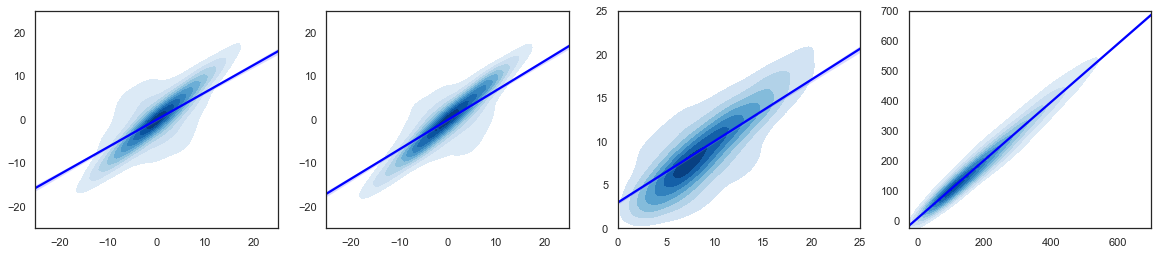

In [16]:
num_first = 5000
# list_lim=[[-1,1],[-1,1],[-1,1],[0,1]]
# list_lim=[[-3,3],[-3,3],[-3,3],[-0.5,7.5]]
list_lim=[[-25,25],[-25,25],[0,25],[-25,700]]

plot_data = collision_data.numpy()
density_plot(plot_data[:,:3], plot_data[:,3:], num_first, list_lim)


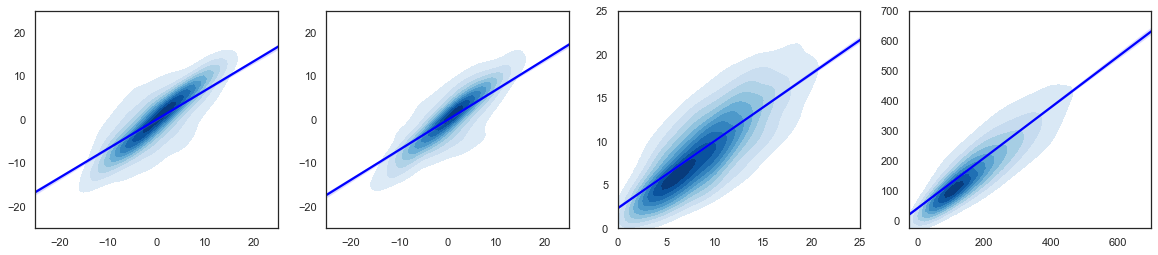

In [17]:
num_test = 5_000
noise = tf.random.normal([num_test, noise_dim])
generated_out = generator(noise, training=False)
# list_lim=[[-3,3],[-3,3],[-3,3],[-0.5,7.5]]
list_lim=[[-25,25],[-25,25],[0,25],[-25,700]]

plot_data = generated_out.numpy()
density_plot(plot_data[:,:3], plot_data[:,3:], num_test, list_lim)
